## Bedrock Example

In [1]:
import boto3
import json
bedrock = boto3.client(service_name='bedrock')
model_list=bedrock.list_foundation_models()
for x in range(len(model_list.get('modelSummaries'))):
     modelName:str = model_list.get('modelSummaries')[x]['modelName']
     if 'nova' in modelName.lower():
         modelId = model_list.get('modelSummaries')[x]['modelId']
         inferenceTypesSupported = model_list.get('modelSummaries')[x]['inferenceTypesSupported']
         print(f" ModelId: {modelId}, ModelName: {modelName}, InferenceTypesSupported: {inferenceTypesSupported}")

 ModelId: amazon.nova-pro-v1:0, ModelName: Nova Pro, InferenceTypesSupported: ['INFERENCE_PROFILE', 'ON_DEMAND']
 ModelId: amazon.nova-lite-v1:0, ModelName: Nova Lite, InferenceTypesSupported: ['INFERENCE_PROFILE', 'ON_DEMAND']
 ModelId: amazon.nova-micro-v1:0, ModelName: Nova Micro, InferenceTypesSupported: ['INFERENCE_PROFILE', 'ON_DEMAND']


In [2]:
import logging
import boto3
boto3.set_stream_logger('', logging.ERROR)
from IPython.display import Markdown, display
def in_md(md_txt):
    md_formated_txt = f"""--- Response ---   
    {md_txt}     
    ----
    """
    display(Markdown(md_formated_txt))

In [3]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage

model = init_chat_model("amazon.nova-pro-v1:0", model_provider="bedrock_converse")

messages = [
    SystemMessage("Create a list with the most popular sightseeing places"),
    HumanMessage("Sir Lanka"),

]

response = model.invoke(messages)
in_md(response.content)

--- Response ---   
    Certainly! Here's a list of some of the most popular sightseeing places in Sri Lanka:

1. **Sigiriya Rock Fortress** 
   - An ancient rock fortress located in the northern Matale District.

2. **Temple of the Tooth (Sri Dalada Maligawa)** 
   - Located in Kandy, it houses the sacred tooth relic of Buddha.

3. **Yala National Park** 
   - One of the most visited national parks, known for its wildlife, especially leopards.

4. **Galle Dutch Fort** 
   - A fortified old town founded by Portuguese in the 16th century and later fortified by Dutch.

5. **Adam’s Peak (Sri Pada)** 
   - A mountain located in central Sri Lanka, venerated by Buddhists, Hindus, Muslims, and Christians.

6. **Anuradhapura**
   - An ancient city and UNESCO World Heritage site, known for its well-preserved ruins of ancient Sinhalese civilization.

7. **Kandy Lake** 
   - An artificial lake in the heart of the hill city of Kandy.

8. **Bundala National Park** 
   - Known for its birdlife and other wildlife.

9. **Udawalawe National Park** 
   - Famous for elephant sightings.

10. **Horton Plains National Park** 
    - Known for World’s End, a dramatic escarpment, and diverse flora and fauna.

11. **Minneriya National Park** 
    - Known for the gathering of elephants.

12. **Dambulla Cave Temple** 
    - A UNESCO World Heritage site with a series of cave temples.

13. **Nine Arch Bridge** 
    - An iconic railway bridge in the Demodara area.

14. **Nuwara Eliya** 
    - A city in the Hill Country known for its tea plantations and scenic beauty.

15. **Polonnaruwa** 
    - Another ancient city and UNESCO World Heritage site, known for its ruins.

These destinations offer a mix of cultural, historical, and natural attractions, making Sri Lanka a diverse and fascinating place to visit.     
    ----
    

In [4]:
import json
print(json.dumps(response.usage_metadata, indent=2))

{
  "input_tokens": 11,
  "output_tokens": 435,
  "total_tokens": 446,
  "input_token_details": {
    "cache_creation": 0,
    "cache_read": 0
  }
}


In [5]:
def multiply(a:int,b) -> int:
    return a*b


In [6]:
model_with_tools = model.bind_tools([multiply])
tool_call = model_with_tools.invoke([HumanMessage(content="what is 2 multiply by 3?")])

In [7]:
tool_call

AIMessage(content=[{'type': 'text', 'text': "<thinking> To find the product of 2 and 3, I will use the 'multiply' tool with the parameters a=2 and b=3. </thinking>\n"}, {'type': 'tool_use', 'name': 'multiply', 'input': {'a': 2, 'b': 3}, 'id': 'tooluse_G3Thm7mDTq-tHiDYZN2-NA'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'e640e650-31e6-46f6-9678-e019a2a30f20', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 16 Sep 2025 22:35:02 GMT', 'content-type': 'application/json', 'content-length': '402', 'connection': 'keep-alive', 'x-amzn-requestid': 'e640e650-31e6-46f6-9678-e019a2a30f20'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': [836]}, 'model_name': 'amazon.nova-pro-v1:0'}, id='run--d0f0ad34-d703-401c-9331-88b7e256034c-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'tooluse_G3Thm7mDTq-tHiDYZN2-NA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 400, 'output_tokens': 55, 'total_tokens': 455, 'input

## Reducers
Need to append verytime, but default is override. 

In [8]:
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MyState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


LangGraph has prebuild `MessagesState` to replace the above `MyState`:

In [9]:
from langgraph.graph import MessagesState
class State(MessagesState):
    pass


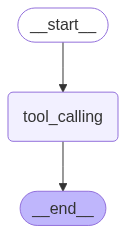

In [22]:
from IPython.display import Image,  display
from langgraph.graph import StateGraph, START, END

def tool_calling_llm(state: State):
    return {'messages': [model_with_tools.invoke(state['messages'])]}

builder = StateGraph(State)
builder.add_node("tool_calling", tool_calling_llm)
builder.add_edge(START, "tool_calling")
builder.add_edge("tool_calling", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
# Human message to graph
results = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})

In [24]:
for m in results['messages']:
    print(f'{m.content =}')

m.content ='Multiply 2 and 3'
m.content =[{'type': 'text', 'text': "<thinking> The user has requested to multiply two numbers, 2 and 3. I can use the 'multiply' tool to perform this calculation. </thinking>\n"}, {'type': 'tool_use', 'name': 'multiply', 'input': {'a': 2, 'b': 3}, 'id': 'tooluse_ExldbkAJT-CovrlTZ8pGcQ'}]


In [4]:
# Import python libraries
import boto3
import json
import sagemaker
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name

# Get the correct Amazon S3 bucket name.
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')

s3 = boto3.resource('s3')



ModuleNotFoundError: No module named 'distutils'